In [1]:
from qutip import mesolve, steadystate
import numpy as np
import optical as EM
import phonons as RC
import leads as FL
from utils import *
from style import *
from photocell_setup import *

utils imported


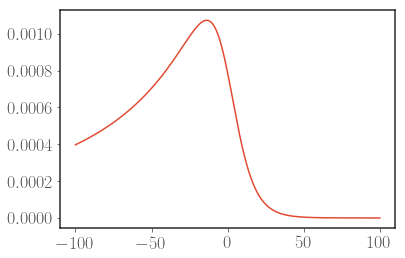

In [2]:
w = np.linspace(-100, 100, 1000)
plt.plot(w, FL.J_Lorentzian(w, 10, 100, Gamma=1)*FL.fermi_occ(w, 10, 0.) )
#plt.plot(w, FL.J_Lorentzian(w, 10,100,Gamma=1)*(1-FL.fermi_occ(w, 10, 0.)))
#plt.plot(w, J_underdamped(w, 10,10,alpha=1/(2*pi)) )
plt.show()

In [36]:
reload(RC)
reload(EM)
reload(FL)

def dynamics( H, L, PARAMS, tf=10, tN=1000):
    timelist = np.linspace(0, tf, tN)
    ops = make_expectation_operators(PARAMS)
    rho_0 = tensor(0.5*(exciton_ket+vac_ket)*(exciton_ket.dag()+vac_ket.dag()), 
                   thermal_dm(PARAMS['N'], Occupation(PARAMS['Omega_RC'], PARAMS['T_ph'])))
    data = mesolve(H, rho_0, timelist, c_ops=[L], e_ops=[ops['exciton'], ops['real_coherence'], 
                                                         ops['imag_coherence']], 
                   options=qt.Options(nsteps=15000))
    plt.figure()
    plt.plot(timelist, data.expect[0])
    plt.figure()
    plt.plot(timelist, data.expect[1])
    plt.show()

def build_full_L(PARAMS, silent=True):
    # RC mapping on operators etc
    PARAMS, L_RC, H_S, A_nrwa, A_RC, A_L, A_R = RC.RC_mapping(PARAMS, silent=silent)
    H = H_S # H_S
    H_add = tensor(PARAMS['H_sub'], qeye(PARAMS['N']))
    # optical liouv and additive
    if PARAMS['radiative_lifetime'] == np.infty:
        L_EM_add = L_EM = 0
    else:
        L_EM = EM.L_non_rwa(H_S, A_nrwa, PARAMS['omega_exciton'], PARAMS['Gamma_EM'], 
                            PARAMS['T_EM'], PARAMS['J'],
                                    silent=silent, tol=0)
    
    #  Left and right leads and additive
    #L_L, L_R = FL.L_R_lead_dissipators(H_S, PARAMS, real_only=False, silent=False)
    L_L, L_R = FL.L_R_lead_dissipators(H, PARAMS, silent=silent)
    # dict of various combinations    
    L_dict = {'PARAMS': PARAMS, 'H_S': H_S, 'L_EM': L_EM, 'L_R': L_R, 
                                            'L_full' : L_EM+L_L+L_R+L_RC}
    return L_dict # dict
    
def build_all_L(PARAMS, silent=True):
    # RC mapping on operators etc
    PARAMS, L_RC, H_S, A_nrwa, A_RC, A_L, A_R = RC.RC_mapping(PARAMS, silent=silent)
    H = H_S # H_S
    H_add = tensor(PARAMS['H_sub'], qeye(PARAMS['N']))
    # optical liouv and additive
    if PARAMS['radiative_lifetime'] == np.infty:
        L_EM_add = L_EM = 0
    else:
        L_EM = EM.L_non_rwa(H_S, A_nrwa, PARAMS['omega_exciton'], PARAMS['Gamma_EM'], 
                            PARAMS['T_EM'], PARAMS['J'],
                                    silent=silent, tol=0)
        L_EM_add = EM.L_non_rwa(H_add, A_nrwa, PARAMS['omega_exciton'], PARAMS['Gamma_EM'], 
                                PARAMS['T_EM'], PARAMS['J'],
                                    silent=silent, tol=0)
    
    #  Left and right leads and additive
    #L_L, L_R = FL.L_R_lead_dissipators(H_S, PARAMS, real_only=False, silent=False)
    L_L, L_R = FL.L_R_lead_dissipators(H, PARAMS, silent=silent)
    L_L_lindblad = FL.L_left_lindblad(H, PARAMS)
    L_R_lindblad = FL.L_right_lindblad(H, PARAMS)
    #print(L_L.eigenenergies())
    #print(L_R.eigenenergies())
    #print(L_L_lindblad.eigenenergies())
    #print(L_R_lindblad.eigenenergies())
    L_L_add, L_R_add = FL.L_left_nonadditive(H_add, PARAMS), FL.L_right_nonadditive(H_add, PARAMS)
    # dict of various combinations    
    L_dict = {'PARAMS': PARAMS, 'H_S': H_S, 'L_EM': L_EM, 'L_R': L_R, 
                                            'L_full' : L_EM+L_L+L_R+L_RC,
                                            'L_lindblad' : L_EM+L_L_lindblad+L_R_lindblad+L_RC,
                                            'L_add_EM' : L_EM_add+L_R+L_L+L_RC,
                                            'L_add_leads' : L_EM+L_L_add+L_R_add+L_RC,
                                            'L_no_EM' : L_R+L_L+L_RC}
    return L_dict # dict
#return H_S, L_RC, L_EM, L_EM_add, L_L, L_R, L_L_add, L_R_add



In [37]:
PARAMS = PARAMS_setup(binding_energy=0.1, radiative_lifetime=np.infty, alpha_ph=0, mu_L=0.0, 
                      bias_voltage=0, N=4, silent=False)
L_dict = build_all_L(PARAMS)
print_PARAMS(PARAMS)
ss = steadystate(L_dict['H_S'], [L_dict['L_full']])
print(ss.ptrace(0))
ss = steadystate(L_dict['H_S'], [L_dict['L_lindblad']])
print(ss.ptrace(0))
"""ss = steadystate(L_dict['H_S'], [L_dict['L_add_leads']])
print(ss.ptrace(0))
ss = steadystate(L_dict['H_S'], [L_dict['L_no_EM']])
print(ss.ptrace(0))
ss = steadystate(L_dict['H_S'], [L_dict['L_no_EM']])
print(ss.ptrace(0))"""

Phonon occupation: 2.12. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=4.
(5.41733588299e-09+0j)
(5.41733588299e-09+0j)
(5.41733588299e-09+0j)
(5.41733588299e-09+0j)
(5.97261156162e-09+0j)
(5.97261156162e-09+0j)
(5.97261156162e-09+0j)
(5.97261156162e-09+0j)
gamma_RC : 0.0159154943092	mu_R : 0.0	mu_L : 0.0	delta_R : 24.1965	energy_shift : 0.0	Omega_RC : 80.655	Omega_ph : 80.655	T_ph : 300.0	binding_energy : 806.55	deformation_ratio : 0.5	radiative_lifetime : inf	leads_lifetime : 1	omega_exciton : 16131.0	Gamma_EM : 0.0	Omega_R : 8468.775	J : <function J_minimal at 0x7fb8ba0e1f50>	omega_v : 8468.775	T_EM : 5800	alpha_ph : 0.0	Omega_L : -8468.775	omega_c : 8468.775	N : 4	Gamma_L : 0.005309	T_L : 300.0	sys_dim : 4	Gamma_ph : 8.0655	delta_L : 24.1965	T_R : 300.0	kappa_RC : 0.0	Gamma_R : 0.005309
Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.5  0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.5  0. ]
 [ 0.   0.   0.   0

"ss = steadystate(L_dict['H_S'], [L_dict['L_add_leads']])\nprint(ss.ptrace(0))\nss = steadystate(L_dict['H_S'], [L_dict['L_no_EM']])\nprint(ss.ptrace(0))\nss = steadystate(L_dict['H_S'], [L_dict['L_no_EM']])\nprint(ss.ptrace(0))"

In [ ]:
300*0.695/ev_to_inv_cm

In [ ]:
PARAMS = PARAMS_setup(binding_energy=0.0, radiative_lifetime=np.infty, alpha_ph=0., mu_L=-1.3, 
                      bias_voltage=8.0, N=4, silent=False)
L_dict = build_all_L(PARAMS)
print_PARAMS(PARAMS)
ss = steadystate(L_dict['H_S'], [L_dict['L_full']])
print(ss.ptrace(0))
ss = steadystate(L_dict['H_S'], [L_dict['L_add_EM']])
print(ss.ptrace(0))
ss = steadystate(L_dict['H_S'], [L_dict['L_add_leads']])
print(ss.ptrace(0))
ss = steadystate(L_dict['H_S'], [L_dict['L_no_EM']])
print(ss.ptrace(0))

In [ ]:
PARAMS = PARAMS_setup(binding_energy=0.1, radiative_lifetime=1, alpha_ph=100e-3, mu_L=0.0, 
                      bias_voltage=0.5, N=14, silent=False)
L_dict = build_all_L(PARAMS)
print_PARAMS(PARAMS)
ss = steadystate(L_dict['H_S'], [L_dict['L_full']])
print(ss.ptrace(0))
ss = steadystate(L_dict['H_S'], [L_dict['L_add_EM']])
print(ss.ptrace(0))
ss = steadystate(L_dict['H_S'], [L_dict['L_add_leads']])
print(ss.ptrace(0))
ss = steadystate(L_dict['H_S'], [L_dict['L_no_EM']])
print(ss.ptrace(0))

In [ ]:
def current_from_L(H, L_full, L_track, n_c):
    obs_out = []
    rho_ss = qt.steadystate(H, [L_full])
    return -(qt.vector_to_operator(L_track*qt.operator_to_vector(rho_ss))*n_c).tr()

def current_and_obs_from_L(H, L_full, L_track, obs_ops):
    obs_out = []
    rho_ss = qt.steadystate(H, [L_full])
    obs_out.append(-(qt.vector_to_operator(L_track*qt.operator_to_vector(rho_ss))*obs_ops[0]).tr())
    for obs in obs_ops[1::]:
        obs_out.append((rho_ss*obs).tr())
    del rho_ss
    return obs_out

def simple_current_voltage(PARAMS):
    bias_voltages = np. linspace(0, PARAMS['omega_exciton']*1.2, 100)
    
    currents = []
    for i, bv in enumerate(bias_voltages):
        PARAMS.update({'mu_R': PARAMS['mu_L']+bv})
        if i in [10, 30, 50, 90]:
            print_PARAMS(PARAMS)
        L_dict = build_full_L(PARAMS, silent=True)
        ops = make_expectation_operators(PARAMS)
        d_e_RC = ops['d_e']
        n_c = d_e_RC.dag()*d_e_RC
        currents.append(current_from_L(L_dict['H_S'], L_dict['L_full'], L_dict['L_R'], n_c))
    return bias_voltages, currents




In [ ]:
PARAMS = PARAMS_setup(binding_energy=0.0, leads_lifetime=2, radiative_lifetime=1, 
                      alpha_ph=0, mu_L=3e-2, bias_voltage=0, N=4, silent=False)
V_values, I = simple_current_voltage(PARAMS)

In [ ]:
I

In [ ]:
np.array(I).real

In [ ]:
plt.plot(V_values, np.array(I).real)
plt.show()

In [ ]:
plt.plot(V_values, I)
plt.show()

In [ ]:
PARAMS